In [1]:
import math
import time
import json
import scipy
import pickle
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,5))

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

In [2]:
df = pd.read_pickle('../data/shippify_icd.pkl', compression='gzip')
df = df.dropna(subset=['pickup_effective_dt', 'delivery_effective'])

### **Agregar codigo necesario debajo de su nombre**

## Enmanuel Magallanes

In [3]:
def with_hue(plot, feature, Number_of_categories, hue_categories):
    a = [p.get_height() for p in plot.patches]
    patch = [p for p in plot.patches]
    for i in range(Number_of_categories):
        total = a[i] + a[i+8]
        for j in range(hue_categories):
            percentage = '{:.1f}%'.format(100 * a[(j*8 + i)]/total)
            x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() / 2 - 0.15
            y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height() 
            plt.annotate(percentage, (x, y), size = 12)
    plt.show()

In [10]:
## Question: cual son las franjas horarias en las que se regitran mas tareas atrasadas y de que (tipo|peso) son?
## Question: Are the heaviest tasks the ones that register the most delays at the time of delivery?

In [4]:
def sum_total_weight(row):
  items = json.loads(row)
  total_weight = 0
  for item in items:
    try:
      total_weight += float(item['weight'])     
    except:
      total_weight += 0
  return total_weight

df['total_weight'] = df['items'].apply(sum_total_weight).astype('float32')

In [5]:
# Remove outlayers
z_scores = stats.zscore(df['total_weight'])
abs_z_scores = np.abs(z_scores)
filtered_entries = abs_z_scores < 3
df = df[ filtered_entries ]

<AxesSubplot:xlabel='total_weight', ylabel='Density'>

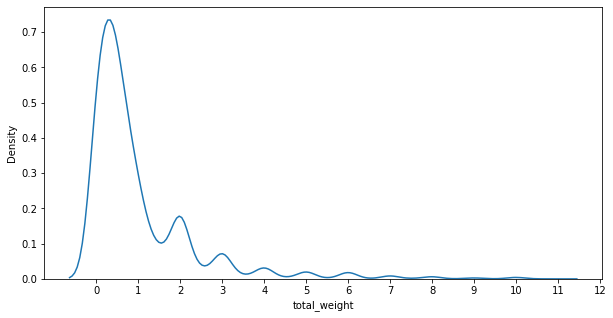

In [6]:
plt.figure(figsize=(10,5))
plt.xticks([x for x in range(16)])
sns.kdeplot(data=df, x='total_weight', bw_adjust=2)

<AxesSubplot:xlabel='total_weight'>

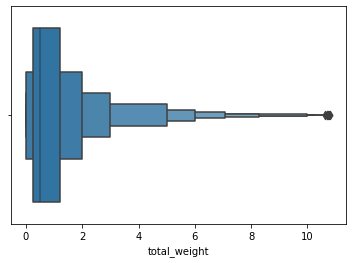

In [7]:
## Boxplot of total_weight
sns.boxenplot(data=df, x='total_weight')

In [8]:
labels = ['[0,0.5) kg', '[0.5,1) kg', '[1,1.5) kg', '[1.5,2) kg', '[2,2.5) kg', '[2.5,3) kg', '[3,3.5) kg', '[3.5 kg,inf) kg']
df['class_weight'] = pd.cut(df['total_weight'], bins=[0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, np.inf], labels=labels, include_lowest=True)

In [9]:
df['class_weight'].value_counts()

[0,0.5) kg         176206
[0.5,1) kg          74690
[1.5,2) kg          35297
[1,1.5) kg          20836
[3.5 kg,inf) kg     18486
[2.5,3) kg          13897
[2,2.5) kg           6549
[3,3.5) kg           2082
Name: class_weight, dtype: int64

In [10]:
df.columns

Index(['id', 'route_id', 'creation_date', 'delivery_type', 'city', 'cost',
       'total_size', 'distance', 'company_id', 'network_id',
       'vehicle_capacity', 'pickup_dt', 'pickup_effective_dt', 'pickuplat',
       'pickuplng', 'pickup_location', 'delivery', 'delivery_effective', 'lat',
       'long', 'delivery_location', 'items', 'total_weight', 'class_weight'],
      dtype='object')

In [11]:
df['is_late'] = df['delivery'] < df['delivery_effective']

In [13]:
gwl = df[['id', 'class_weight', 'is_late']].groupby(['class_weight', 'is_late'])['id'].count().reset_index()

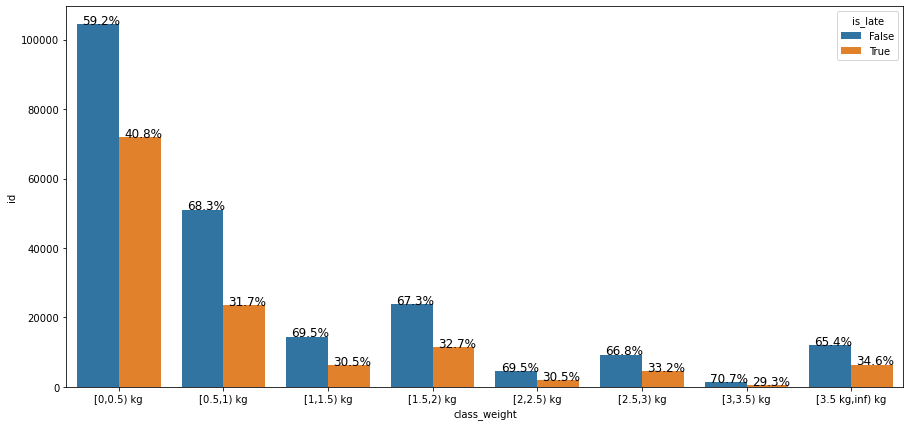

In [14]:
plt.figure(figsize=(15,7))
f = sns.barplot(data=gwl, x='class_weight', y='id', hue='is_late')
with_hue(f, df.class_weight, 8, 2)

A primera vista, el porcentaje de paquetes retrasados no es ni directa ni directamente proporcional al peso. Esto debido a que no se registra un aumento o disminución en el porcentaje de paquetes con atrasos, conforme aumenta su peso. Por tanto, el peso total de la entrega no afecta a la puntualidad de la misma.


In [21]:
## Question 2: La intensidad del trafico en el punto destino de una entrega influje en la puntualidad de la misma?
## cantidad de entregas en un radio específico
## considerar la densidad de entregas en un radio especifico, en una ventana de tiempo. 
# Basado en lat.long un radio de X km y basado en delivery date una ventana de X horas, cuantas entregas hay
## considerar cuantas entregas fueron creadas ese día en esa ciudad

### Hour late vs Total weight

In [52]:
diff = df['delivery'] - df['delivery_effective']
df['delay_delivery'] = diff.apply(lambda x: abs(int(x.total_seconds()))) / 3600

## Josue Cobos

In [ ]:
#Question: Are those deliveries that are further from the economic center of Belo Horizonte those with the longest delivery delay?

In [ ]:
#calculate distance between 2 lat long points
def calculateDistance(point, anotherPoint):
    lat1, lon1 = point
    lat2, lon2 = anotherPoint 
    R = 6373.0
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance #kilometers

In [48]:
#For this question we will assume Barreiro in the most important regional administration of Belo Horizonte
BARREIROPOINT = (-19.977, -44.0145)
def getDistanceFromA(row):
  #print(row)
  return calculateDistance(BARREIROPOINT, (row['lat'], row['long']))
  #return row #distance

In [ ]:
df['dst_to_barreiro'] = df[['lat', 'long']].apply(getDistanceFromA, axis=1)

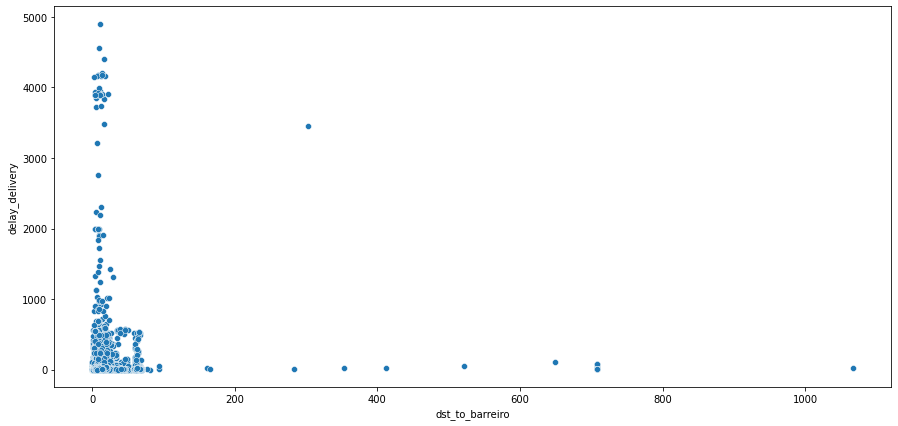

In [54]:
plt.figure(figsize=(15,7))
subdf = df[['dst_to_barreiro','delay_delivery']]
f2 = sns.scatterplot(x=subdf['dst_to_barreiro'], y=subdf['delay_delivery'])
#with_hue(f, df.class_weight, 8, 2)

In [56]:
subdf.corr()

,dst_to_barreiro,delay_delivery
dst_to_barreiro,1.000000,0.020953
delay_delivery,0.020953,1.000000


In [ ]:
#Answer: Due to the non-existent correlation between the delay of shipments (delay_delivery) and distance to Barreiro (dst_to_barreiro), we can conclude that no matter how far your order is, it does not necessarily mean that it has a longer delay time.